In [67]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'
plt.style.use('ggplot')
import astropy.units as u
import astropy.constants as const
import ipywidgets as widgets
import ipywidgets
from IPython.display import clear_output

import utils

In [68]:
def phase_shifter(beam:complex, power:float, length:float=1, wavelength:float=3) -> complex:
    """------------------------------------------------------------------------
    De-phase the input beam by heating the fiber with an electrical current.
    
    Parameters
    ----------
    - `beam` : Input beam complex amplitude
    - `power` : Input power in Watts
    - `length` : Fiber length in milimeters
    - `wavelength` : Wavelength in microns
    
    Returns
    -------
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""

    # TODO: Implement a physical f(power, length, wavelength) function

    return beam * np.exp(1j * np.array(power) * np.pi)

def mach_zehnder(beam:complex, power:float) -> complex:
    """------------------------------------------------------------------------
    Partially or totally cancel the light of a beam by
    splitting it in two part, dephasing one path and recombining them.
    
    Parameters
    ----------
    - `input_beam` : Input beam complex amplitude
    - `input_power` : Input power in Watts for the dephasing.
    
    Returns
    -------
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""

    return (beam + phase_shifter(beam, power)) / 2

def random_phase_pertubation(beam:complex, rms:float) -> complex:
    """------------------------------------------------------------------------
    Add a random phase pertubation to the input beam.
    
    Parameters
    ----------
    - `beam` : Input beam complex amplitude
    - `rms` : Root mean square of the phase pertubation in radians
    
    Returns
    -------
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""

    return beam * np.exp(1j * np.random.normal(scale=rms)) 

def random_amplitude_pertubation(beam:complex, rms:float) -> complex:
    """------------------------------------------------------------------------
    Add a random amplitude pertubation to the input beam.
    
    Parameters
    ----------
    - `beam` : Input beam complex amplitude
    - `rms` : Root mean square of the relative amplitude pertubation
    
    Returns
    -------
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""

    return beam * np.random.normal(scale=rms)

def random_phase_and_amplitude_pertubation(beam:complex, phase_rms:float, amplitude_rms:float) -> complex:
    """------------------------------------------------------------------------
    Add a random phase and amplitude pertubation to the input beam.
    
    Parameters
    ----------
    - `beam` : Input beam complex amplitude
    - `phase_rms` : Root mean square of the phase pertubation in radians
    - `amplitude_rms` : Root mean square of the relative amplitude pertubation
    
    Returns
    -------
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""

    return beam * random_phase_pertubation(1, phase_rms) * random_amplitude_pertubation(1, amplitude_rms)

def nuller4x4(beams:list[complex]) -> tuple[complex, list[complex]]:
    """------------------------------------------------------------------------
    Simulate a 4 input beam nuller.
    
    Parameters
    ----------
    - `beams` : List of 4 input beams complex amplitudes
    
    Returns
    -------
    - Bright channel complex amplitude
    - List of 3 dark channels complex amplitudes
    ------------------------------------------------------------------------"""

    N = 1/np.sqrt(4) * np.array([
        [1,  1,  1,  1],
        [1,  1, -1, -1],
        [1, -1,  1, -1],
        [1, -1, -1,  1]
    ])
    
    outputs = N @ beams

    return outputs[0], outputs[1:]

def nuller_2x2(beams:np.array) -> np.array:
    """------------------------------------------------------------------------
    Simulate a 2 input beam nuller.

    Parameters
    ----------
    - `beams` : Array of 2 input beams complex amplitudes

    Returns
    -------
    - Array of 2 output beams complex amplitudes
        - 1st output is the bright channel
        - 2nd output is the dark channel
    ------------------------------------------------------------------------"""

    N = 1/np.sqrt(2) * np.array([
        [1,   1],
        [1,  -1],
    ])

    return N @ beams

def splitmix_4x4(beams:list[complex]) -> list[complex]:
    """------------------------------------------------------------------------
    Simulate a 3 input beam split and mix.
    
    Parameters
    ----------
    - `beams` : List of input beams complex amplitudes 
    
    Returns
    -------
    - List of output beams complex amplitudes
        --------------------------------------------------------------------"""
    
    phi = np.pi/4
    S = 1/np.sqrt(4) * np.array([
        [1               , np.exp(1j*phi)  , 0             ],
        [-np.exp(-1j*phi), 1               , 0             ],
        [1               , 0               , np.exp(1j*phi)],
        [-np.exp(-1j*phi), 0               , 1             ],
        [0               , 1               , np.exp(1j*phi)],
        [0               , -np.exp(-1j*phi), 1             ]
    ])

    return S @ beams

def splitmix_2x2(beams:np.array, theta=np.pi/2) -> np.array:
    """------------------------------------------------------------------------
    Simulate a 2 input beam split and mix.

    Parameters
    ----------
    - `beams` : Array of 2 input beams complex amplitudes
    - `theta` : Phase shift between the two output beams

    Returns
    -------
    - Array of 2 output beams complex amplitudes
    ------------------------------------------------------------------------"""

    S = 1/np.sqrt(2) * np.array([
        [np.exp(1j*theta/2), np.exp(-1j*theta/2)],
        [np.exp(-1j*theta/2), np.exp(1j*theta/2)]
    ])

    return S @ beams


<div align=center>

---

# Kernel Nulling Model V0

</div>

In [69]:
class KernelNullerV0:
    def __init__(
            self,
            shifters_offset:np.array=None,
            input_phase_rms:float=0.1,
            input_amplitude_rms:float=0.01,
            inner_phase_rms:float=0.1,
            inner_amplitude_rms:float=0.01
        ):
        """--------------------------------------------------------------------
        Create a 4 telescope Kernel-Nuller (version 0)
        
        Parameters
        ----------
        - `shift_powers` : Input phase corrective power
        - `phase_rms` : Root mean square of the phase pertubation in radians
        - `amplitude_rms` : Root mean square of the relative amplitude pertubation
        --------------------------------------------------------------------"""

        self.shifters_offset = shifters_offset
        
        self._input_perturbations = np.random.normal(scale=input_phase_rms, size=4)
        self._nuller_perturbations = np.random.normal(scale=inner_phase_rms, size=4)
        self._splitmix_perturbations = np.random.normal(scale=inner_phase_rms, size=6)

        self._perturbations = np.concatenate([
            self._input_perturbations,
            self._nuller_perturbations,
            self._splitmix_perturbations
        ])

        print("Perturbations:", self._perturbations)

    @property
    def shifters_offset(self):
        return self._shifters_offset
    
    @shifters_offset.setter
    def shifters_offset(self, value:list[float]):
        assert len(value) == 14, "shift_powers must be a list of 14 floats"
        self._shifters_offset = KernelNullerV0.bound_phase(np.array(value).astype(float))

    @property
    def perturbations(self):
        return self._perturbations
    
    @perturbations.setter
    def perturbations(self, value:list[float]):
        assert len(value) == 14, "perturbations must be a list of 14 floats"
        self._perturbations = KernelNullerV0.bound_phase(np.array(value).astype(float))
    
    @staticmethod
    def bound_phase(phase:np.array) -> np.array:
        return (phase + 1) % 2 - 1

    def __call__(self, beams:np.array, shifts:np.array=None) -> tuple[complex, np.array, dict[np.array]]:
        """--------------------------------------------------------------------
        Simulate a 4 telescope Kernel-Nuller propagation
        
        Parameters
        ----------
        - `beams` : List of input beams complex amplitudes
        - `shifts` : List of input phase corrections
        
        Returns
        -------
        - Bright channel complex amplitude
        - List of dark channels complex amplitudes
        --------------------------------------------------------------------"""
    
        # If no shift_powers are provided, use the default ones
        if shifts is None:
            shifts = [0]*14
        
        # Add perturbations
        shifts = np.array(shifts) + self.shifters_offset + self.perturbations
        shifts = KernelNullerV0.bound_phase(shifts)

        # First layer of pahse shifters
        null_inputs = phase_shifter(beams, shifts[:4])

        # First layer of nulling
        N1_output = nuller_2x2(null_inputs[:2])
        N2_output = nuller_2x2(null_inputs[2:])

        # Second layer of phase shifters
        N1_output_shifted = phase_shifter(N1_output, shifts[4:6])
        N2_output_shifted = phase_shifter(N2_output, shifts[6:8])

        # Second layer of nulling
        N3_output = nuller_2x2(np.array([N1_output_shifted[0], N2_output_shifted[0]]))
        N4_output = nuller_2x2(np.array([N1_output_shifted[1], N2_output_shifted[1]]))

        bright_channel = N3_output[0]

        # Beam splitting
        S_inputs = np.array([
            N3_output[1],
            N3_output[1],
            N4_output[0],
            N4_output[0],
            N4_output[1],
            N4_output[1]
        ]) * 1/np.sqrt(2)

        # Last layer of phase shifters
        S_inputs = phase_shifter(S_inputs, shifts[8:])

        # Beam mixing
        S1_output = splitmix_2x2(np.array([S_inputs[0],S_inputs[2]]))
        S2_output = splitmix_2x2(np.array([S_inputs[1],S_inputs[4]]))
        S3_output = splitmix_2x2(np.array([S_inputs[3],S_inputs[5]]))

        dark_channels = np.concatenate([S1_output, S2_output, S3_output])

        return bright_channel, dark_channels, {"inputs":beams, "first_nuller_layer":np.concatenate([N1_output,N2_output]),"second_nuller_layer":np.concatenate([N3_output,N4_output])}

# Kernel Nulling instance

In [70]:
kn0 = KernelNullerV0(
    shifters_offset=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    input_phase_rms=1,
    input_amplitude_rms=0,
    inner_phase_rms=1,
    inner_amplitude_rms=0
)

star_light = np.array([
    1 * np.exp(0j),
    1 * np.exp(0j),
    1 * np.exp(0j),
    1 * np.exp(0j),
], dtype=complex)

planet_light = np.array([
    np.exp(1j * 0.10),
    np.exp(1j * -0.12),
    np.exp(1j * 0.05),
    np.exp(1j * -0.01),
], dtype=complex)

Perturbations: [-0.71376316  0.9405552  -0.225861   -1.10366464 -0.86738047  0.77245315
  0.0211103   0.85190231  0.27044483 -0.37423241  0.7648875   0.35286533
  1.96987731  0.77852558]


<div align=center>

---

# GUI

</div>

In [71]:
max_power = 1
step = 1e-20

# Build sliders
P_sliders = [widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description=f"P{i+1}") for i in range(14)]

bright, darks, intermediate = kn0(star_light)

def beam_repr(beam:complex) -> str:
    return f"{np.abs(beam):.3e} * exp({np.angle(beam)/np.pi:.3e} pi i)"   

inputs = [widgets.Label(value=f" ") for _ in range(4)]
first_nuller_layer = [widgets.Label(value=f" ") for _ in range(4)]
second_nuller_layer = [widgets.Label(value=f" ") for _ in range(4)]
outputs = [widgets.Label(value=f" ") for _ in range(7)]

def update_gui(*args):

    kn0.shift_powers = np.array([x.value for x in P_sliders])

    bright, darks, inter = kn0(star_light)

    for i, beam in enumerate(inter['inputs']):
        inputs[i].value = f"Input {i+1}: {beam_repr(beam)}"

    for i, beam in enumerate(inter['first_nuller_layer']):
        first_nuller_layer[i].value = f"N{i//2+1} : {i%2}: {beam_repr(beam)}"

    for i, beam in enumerate(inter['second_nuller_layer']):
        second_nuller_layer[i].value = f"N{i//2+3} : {i%2}: {beam_repr(beam)}"

    outputs[0].value = f"Bright : {beam_repr(bright)}"
    for i, beam in enumerate(darks): 
        outputs[i+1].value = f"Dark {i+1}: {beam_repr(beam)}"

    return bright, darks


for widget in P_sliders:
    widget.observe(update_gui, 'value')

empty = widgets.Label()

vbox = widgets.VBox([
    *[widgets.HBox([x]) for x in inputs],

    widgets.Label("1st nuller layer phase corrective powers:"),
    widgets.HBox(P_sliders[:4]),

    *[widgets.HBox([x]) for x in first_nuller_layer],

    widgets.Label("2nd nuller layer phase corrective powers:"),
    widgets.HBox(P_sliders[4:8]),
    
    *[widgets.HBox([x]) for x in second_nuller_layer],

    widgets.Label("Split & Mix phase corrective powers:"),
    widgets.HBox(P_sliders[8:11]),
    widgets.HBox(P_sliders[11:14]),

    *[widgets.HBox([x]) for x in outputs],
])

update_gui()
vbox

<div align=center>

---

# Convergence

</div>

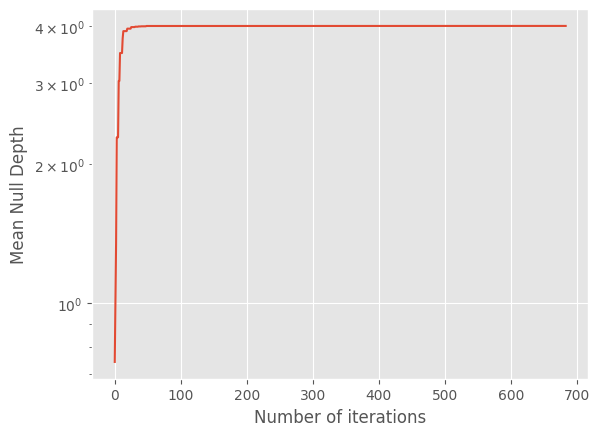

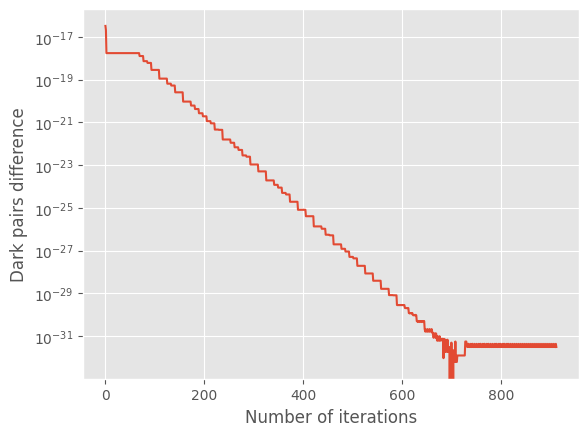

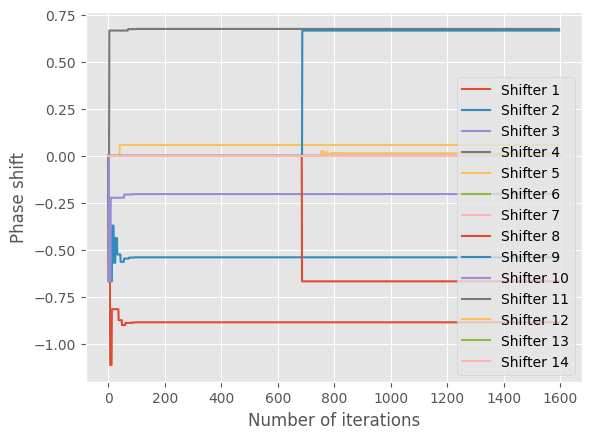

-8.85e-01 | -7.14e-01
-5.39e-01 | 9.41e-01
-2.03e-01 | -2.26e-01
6.75e-01 | -1.10e+00
5.85e-02 | -8.67e-01
-1.93e-16 | 7.72e-01
4.14e-14 | 2.11e-02
-6.67e-01 | 8.52e-01
6.67e-01 | 2.70e-01
4.73e-17 | -3.74e-01
1.89e-16 | 7.65e-01
1.50e-02 | 3.53e-01
0.00e+00 | 1.97e+00
-7.87e-16 | 7.79e-01


In [72]:
optimized_parameters = kn0.shift_powers
optimized_parameters, bright_evol, dark_symmetry_evol, shifts_evol = utils.optimize(kn0, star_light, verbose=False)

plt.figure()
plt.plot(bright_evol)
plt.xlabel("Number of iterations")
plt.ylabel("Mean Null Depth")
plt.yscale("log")
plt.show()

plt.figure()
plt.plot(dark_symmetry_evol)
plt.xlabel("Number of iterations")
plt.ylabel("Dark pairs difference")
plt.yscale("log")
plt.show()

plt.figure()
for i in range(len(kn0.shift_powers)):
    plt.plot(shifts_evol[:,i], label=f"Shifter {i+1}")
plt.xlabel("Number of iterations")
plt.ylabel("Phase shift")
plt.yscale("linear")
plt.legend()
plt.show()

for i in range(len(kn0.shift_powers)):
    print(f"{optimized_parameters[i]:.2e}" + ' | ' + f"{kn0.shifters_offset[i] + kn0.perturbations[i]:.2e}")

# Parameter impact

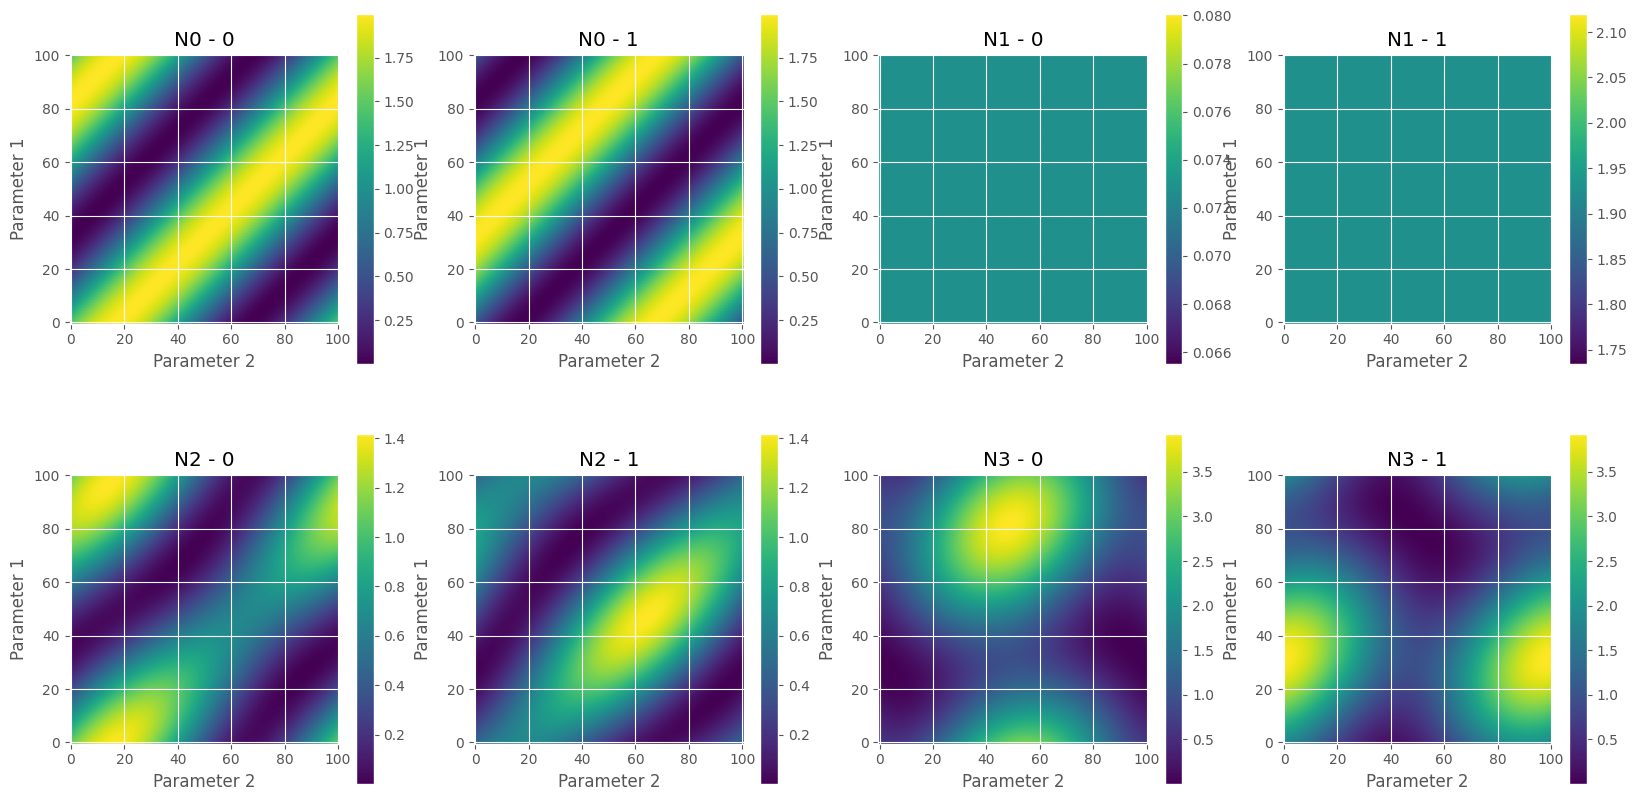

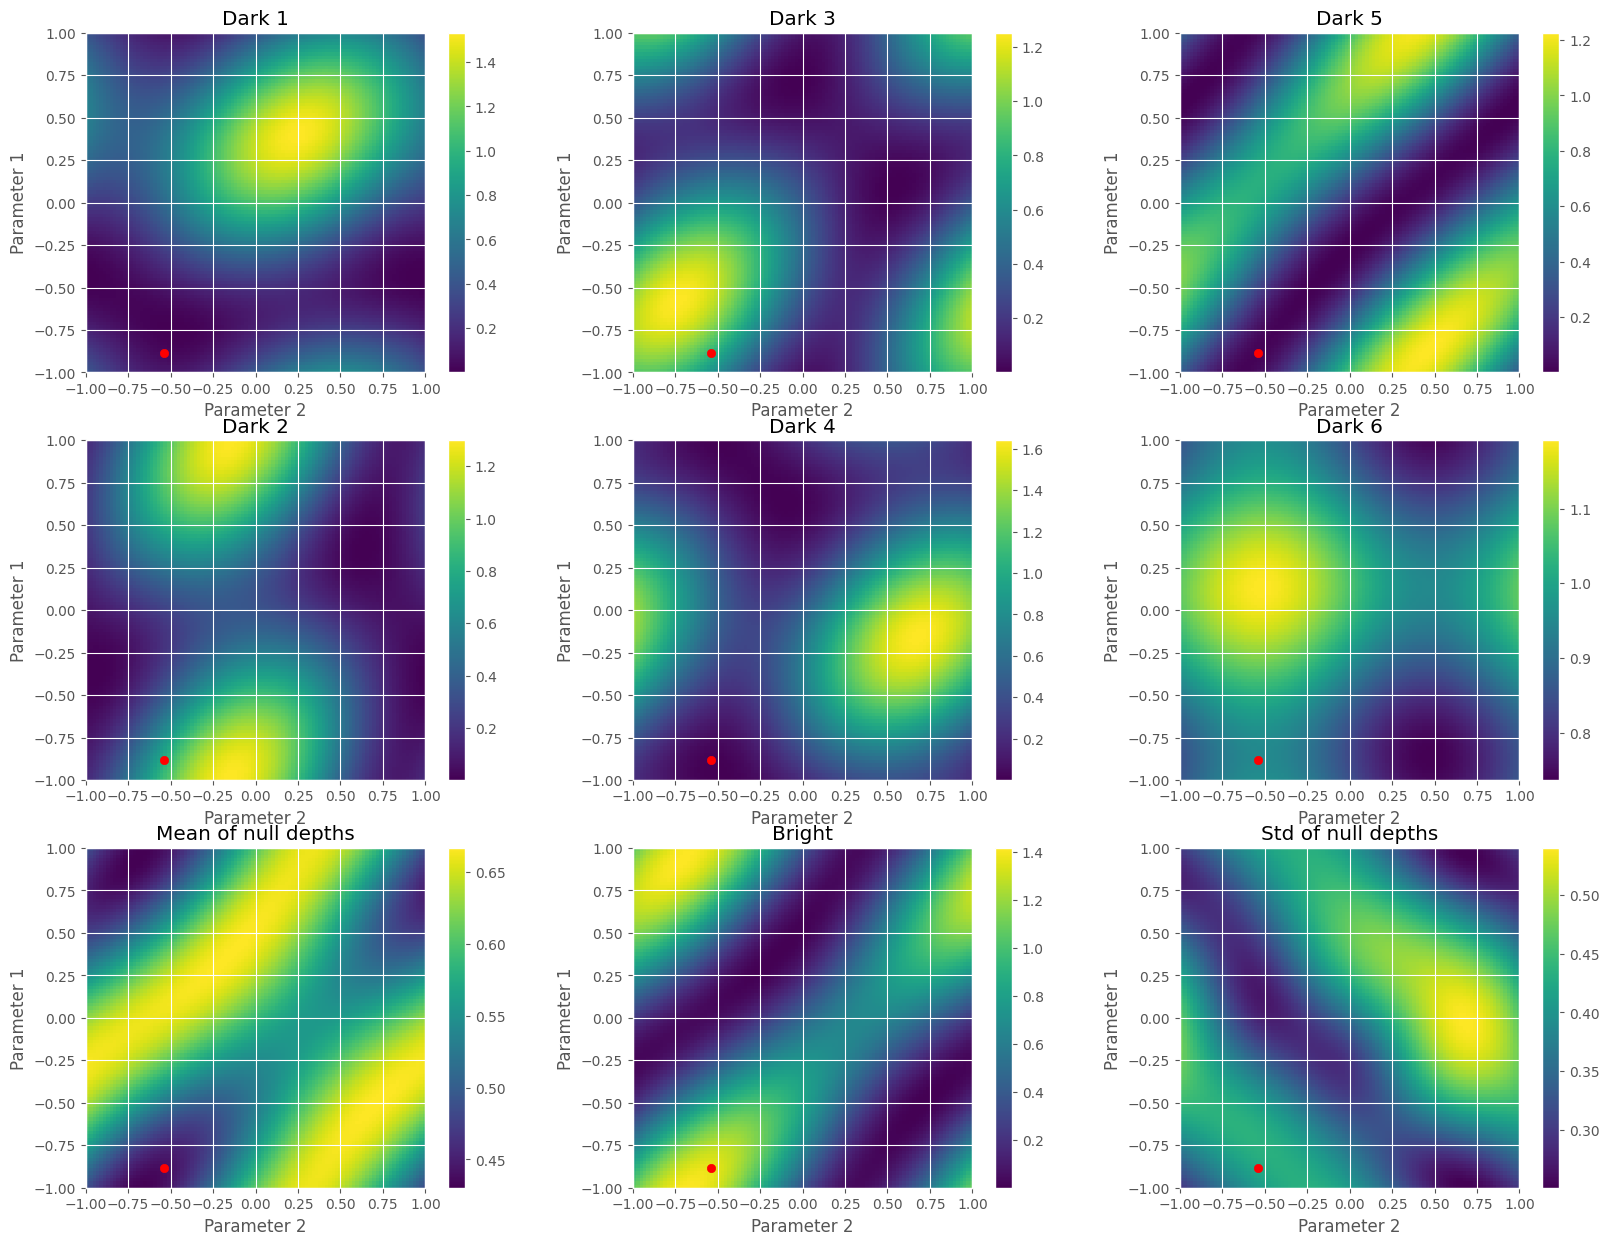

In [73]:
utils.scan(
    kn=kn0, 
    beams=star_light,
    scan_on=(1,2),
    initial_parameters=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    optimized_parameters=optimized_parameters,
    plot_intermediate_states=True
)